# Thresholding

This notebook will show the tours whilst adjusting the threshold value.

Each edge has a probability of being in the final tour. By adjusting this threshold, we can adjust the amount of true edges are in the tour.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

os.environ['PROJ_LIB'] = os.environ['CONDA_PREFIX'] + '\\Library\\share' # bug fix with anaconda and basemap
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import joblib

import model_utils as M

%matplotlib inline

In [19]:
set_idx = 1 # This variable allows you to preview different tours within the test set.
THRESHOLD = 0.2 # Threshold for all the tours.

Load in the models.

In [3]:
TSP_NB = joblib.load('Models/TSP_NB_model.pkl')
TSP_LR = joblib.load('Models/TSP_LR_model.pkl')
TSP_RF = joblib.load('Models/TSP_RF_model.pkl')

Import the data and split into Training and Testing sets.

In [4]:
DATA_DIR = '../6_feature_engineering/Feature_Dataset/'
data_files = [i for i in os.listdir(DATA_DIR) if i.endswith('.csv')]
data_files.sort()
df_TSP_list = [pd.read_csv(DATA_DIR + file) for file in data_files]

for i in range(len(df_TSP_list)):
    # Convert booleans to int
    df_TSP_list[i] = df_TSP_list[i].astype({'IS_IN_1ST_QUARTILE': 'int64',
                                            'IS_IN_2ND_QUARTILE': 'int64',
                                            'IS_IN_3RD_QUARTILE': 'int64',
                                            'EDGE_IN_SOL': 'int64'})
    df_TSP_list[i] = df_TSP_list[i].reset_index(drop=True)
    
df_TSP_list[0].head()

,DISTANCE_KM,Local Rank Incident to Node1,Local Rank Incident to Node2,GLOBAL_RANK,IS_IN_1ST_QUARTILE,IS_IN_2ND_QUARTILE,IS_IN_3RD_QUARTILE,EDGE_IN_SOL
0,108,183,246,83596,1,1,1,0
1,384,926,780,396911,0,0,0,0
2,11,3,2,2752,1,1,1,0
3,168,346,461,156459,0,1,1,0
4,402,954,771,406968,0,0,0,0


In [5]:
train_set = df_TSP_list[:5]
test_set = df_TSP_list[5:]

print("Train Data Graphs:\t{}".format(len(train_set)))
print("Test Data Graphs:\t{}".format(len(test_set)))

Train Data Graphs:	5
Test Data Graphs:	5


Load in the coordinate data.

In [6]:
COORD_DATA_DIR = '../5_ground_truth/Final_Dataset/'
coord_datafiles = [i for i in os.listdir(COORD_DATA_DIR) if i.endswith('.csv')]
coord_datafiles.sort()

df_coord_list = [pd.read_csv(COORD_DATA_DIR + file) for file in coord_datafiles]

for i in range(len(df_coord_list)):
    df_coord_list[i]['NODE1_COORDS'] = df_coord_list[i]['NODE1_COORDS'].apply(eval)
    df_coord_list[i]['NODE2_COORDS'] = df_coord_list[i]['NODE2_COORDS'].apply(eval)

    
coords_train_list = df_coord_list[:5]
coords_test_list = df_coord_list[5:]

coords_test_list[set_idx].head()

,DISTANCE_KM,"EDGE(Node1_ID, Node2_ID)",NODE1_COORDS,NODE2_COORDS,GEODESIC_DISTANCE_KM,GEODESIC_ROUNDED_DISTANCE_KM,EDGE_IN_SOL
0,256,"(0, 1)","(52.927931, -1.214052)","(51.330937, -2.738181)",206.070849,206.0,False
1,115,"(0, 2)","(52.927931, -1.214052)","(53.412186, -3.042255)",133.603733,134.0,False
2,223,"(0, 3)","(52.927931, -1.214052)","(51.4509, 0.058531)",185.963668,186.0,False
3,230,"(0, 4)","(52.927931, -1.214052)","(51.453412, -2.625179)",190.337676,190.0,False
4,201,"(0, 5)","(52.927931, -1.214052)","(51.446623, -1.293458)",164.915875,165.0,False


Find the bounds of the data.

In [7]:
PUBS_DATA = '../1_pubs_crawler/pubs.csv'

df_pubs = pd.read_csv(PUBS_DATA)
df_pubs

BBox = ((df_pubs.longitude.min(), df_pubs.longitude.max(),
         df_pubs.latitude.min(), df_pubs.latitude.max()))
BBox

(-8.092521, 1.757632, 49.8951434, 60.798323967069365)

Define the function to plot the tours.

In [8]:
def plot_tour(node_1_coords, node_2_coords, ground_truth=None):
    fig = plt.figure(figsize=(12,9))

    m = Basemap(projection='mill',
                llcrnrlat=BBox[2],
                urcrnrlat=BBox[3],
                llcrnrlon=BBox[0],
                urcrnrlon=BBox[1],
                resolution='i')

    m.drawcoastlines()

    for i in range(len(node_1_coords)):
        longs = []
        lats = []
        coord1 = node_1_coords.iloc[i]
        coord2 = node_2_coords.iloc[i]
        longs.append(coord1[1])
        lats.append(coord1[0])
        longs.append(coord2[1])
        lats.append(coord2[0])
        if ground_truth is None:
            m.plot(longs, lats, latlon=True, color='red', linewidth=1, marker='o', markersize=2, markerfacecolor='blue')
        else:
            if ground_truth.iloc[i]:  # If this edge is a part of the ground truth
                m.plot(longs, lats, latlon=True, color='blue', linewidth=1, marker='o', markersize=2, markerfacecolor='blue')
            else:
                m.plot(longs, lats, latlon=True, color='red', linewidth=1, marker='o', markersize=2, markerfacecolor='blue')

    plt.title("")
    plt.show()

## Ground Truth Tour

In [9]:
df_ground_truth = coords_test_list[set_idx][coords_test_list[set_idx]['EDGE_IN_SOL']]
df_ground_truth.head()

,DISTANCE_KM,"EDGE(Node1_ID, Node2_ID)",NODE1_COORDS,NODE2_COORDS,GEODESIC_DISTANCE_KM,GEODESIC_ROUNDED_DISTANCE_KM,EDGE_IN_SOL
206,3,"(0, 207)","(52.927931, -1.214052)","(52.939199, -1.216028)",1.260979,1.0,True
765,8,"(0, 766)","(52.927931, -1.214052)","(52.951042, -1.153816)",4.797399,5.0,True
1496,14,"(1, 499)","(51.330937, -2.738181)","(50.941674, -2.626516)",44.005451,44.0,True
1904,7,"(1, 907)","(51.330937, -2.738181)","(50.895765, -2.751493)",48.422052,48.0,True
2906,6,"(2, 912)","(53.412186, -3.042255)","(53.392312, -3.011117)",3.030098,3.0,True


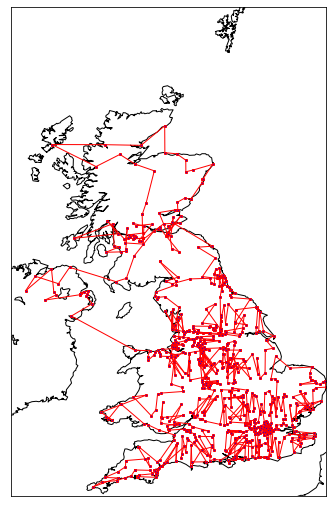

In [10]:
plot_tour(df_ground_truth['NODE1_COORDS'], df_ground_truth['NODE2_COORDS'])

## Naïve Bayes tour

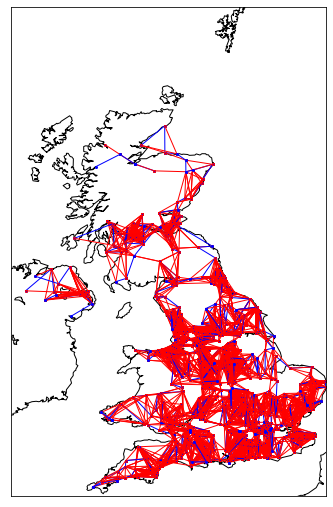

In [16]:
cols = test_set[set_idx].columns[:-1]  # Every column except the last one
X = test_set[set_idx][cols].values

RF_thresh_tour = M.threshold_tour(X, coords_test_list[set_idx], TSP_NB, threshold=THRESHOLD)
plot_tour(RF_thresh_tour['NODE1_COORDS'], RF_thresh_tour['NODE2_COORDS'], RF_thresh_tour['EDGE_IN_SOL'])

## Logisitc Regression Tour

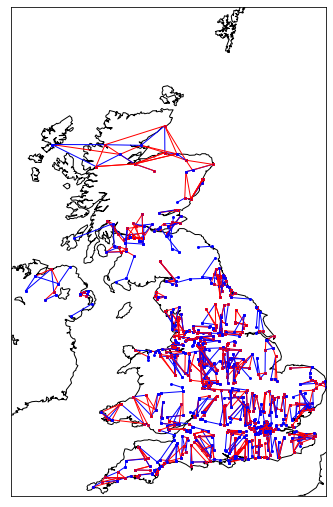

In [17]:
cols = test_set[set_idx].columns[:-1]  # Every column except the last one
X = test_set[set_idx][cols].values

RF_thresh_tour = M.threshold_tour(X, coords_test_list[set_idx], TSP_LR, threshold=THRESHOLD)
plot_tour(RF_thresh_tour['NODE1_COORDS'], RF_thresh_tour['NODE2_COORDS'], RF_thresh_tour['EDGE_IN_SOL'])

## Random Forest Tour

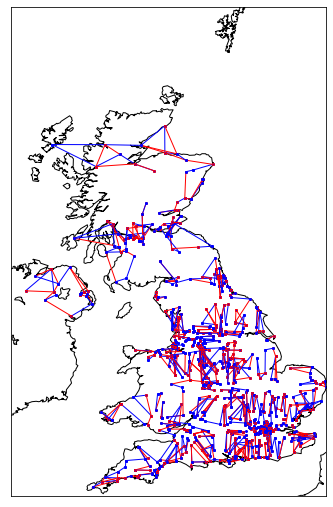

In [18]:
cols = test_set[set_idx].columns[:-1]  # Every column except the last one
X = test_set[set_idx][cols].values

RF_thresh_tour = M.threshold_tour(X, coords_test_list[set_idx], TSP_RF, threshold=THRESHOLD)
plot_tour(RF_thresh_tour['NODE1_COORDS'], RF_thresh_tour['NODE2_COORDS'], RF_thresh_tour['EDGE_IN_SOL'])